In [ ]:
### 4C16 Lab 5 - Convolutional Neural Nets for Image Classification.
# see handout-06
# https://frcs.github.io/4C16-LectureNotes/

In [ ]:
# Note: the training will run significantly faster if you run your notebook as a GPU instance.
# to change to GPU mode, you need to go in the colab menu to Runtime>Change runtime type
# then select "hardware accelerator" to GPU.
# This will restart your instance (obviously), so everytime you do this you'll need to
# start your again from the start of the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-05/

In [ ]:
# Import the necessary modules

import tensorflow as tf

import keras
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import PReLU, LeakyReLU, Conv2D, MaxPool2D, Lambda
from keras.regularizers import l2

from keras.models import model_from_json

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [ ]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        
def save_model_to_disk():    
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to model.json and weights to model.h5")

In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/cifar10-dataset.pkl http://4c16.ml/~mindfreeze/cifar10-dataset.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  5656k      0  0:00:26  0:00:26 --:--:-- 6316k


loading the dataset...
loaded.
let's look at some of the pictures and their ground truth labels:


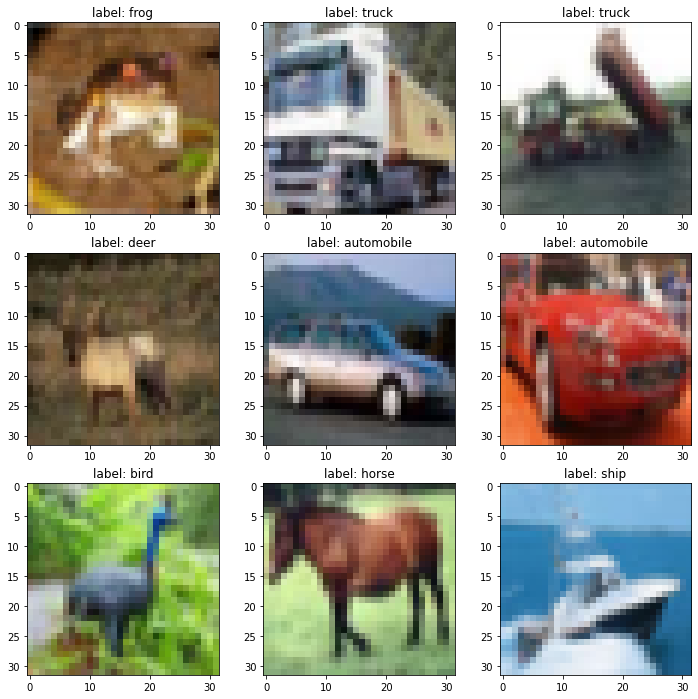

In [ ]:
print('loading the dataset...')

pkl_file = open('/home/tcd/data/cifar10-dataset.pkl', 'rb')
dataset = pickle.load(pkl_file)

print('loaded.')

print('let\'s look at some of the pictures and their ground truth labels:')

plt.figure(figsize=(12,12))
plt.plot([3, 3])

X = dataset['X'].astype('float32')/255
Y = dataset['Y'].astype('float32')
Y = tf.keras.utils.to_categorical(Y)

for i in range(0,9):
    # pictures are 32x32x3 (width=32, height=32, 3 colour channels)
    pic = X[i]

    # Y[i] returns an array of zeros and with Y[i][classid] = 1
    # for instance  Y[i] = [ 0 0 0 0 0 1 0 0 0 0] => classid=5 
    #          and  Y[i] = [ 1 0 0 0 0 0 0 0 0 0] => classid=0
    # we can get the classid by using the argmax function on the vector Y[i]
    classid = Y[i].argmax(-1)

    # getting back the name of the label for that classid
    classname = dataset['labels'][classid]
    plt.subplot(3,3,i+1)
    plt.imshow(pic)
    plt.title('label: {}'.format(classname))


In [ ]:
# let's split data between validation set and training set

X_train, X_validation, Y_train, Y_validation = skl.model_selection.train_test_split(X, Y, test_size=.1)

In [ ]:
# The model below contains 2 hidden layers with 64 nodes each. 
# The activation functions for these 2 layers is the ReLU
# The network ends with a 10 nodes layer with softmax activation
# The first 2 hidden layers transform the original features into 
# a new feature vector of size 64.
# The last layer essentially does the classification using multonomial regression
# based on these new features. 

inputs = keras.layers.Input(shape=(32, 32, 3))


x = inputs  # Don't flatten until after your 2D layers 

### 1st Block
x = Conv2D(256, (3,3), strides=(1,1), padding='valid', activation='relu')(x)
x = Conv2D(256, (3,3), strides=(1,1), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.2)(x)

### 2nd Block
x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu')(x)
x = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(0.2)(x)

### 3rd Block
x = Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu')(x)
x = Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)

# put here some convolutional layers;
# see keras docs for Conv2D, MaxPool2D, etc.
# Maybe stick in some Dropout as well?

# The last layers of your model should look something like
# this to be well-structured for the final classification:
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)  # You could have a few more non-2D layers here
x = Dense(256, activation='relu')(x) 
x = Dense(128, activation='relu')(x) 

predictions = Dense(10, activation='softmax')(x)  # There are 10 classes in this problem, hence the '10'.



# Create the model.
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Setup the optimisation strategy.
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display a summary.
model.summary()

# Keep things sane.
if (model.count_params() > 10000000):    
    raise("Your model is unecessarily complex, scale down!")


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 256)       7168      
                                                                 
 conv2d_19 (Conv2D)          (None, 30, 30, 256)       590080    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_23 (Dropout)        (None, 15, 15, 256)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 15, 15, 128)       295040    
                                                           

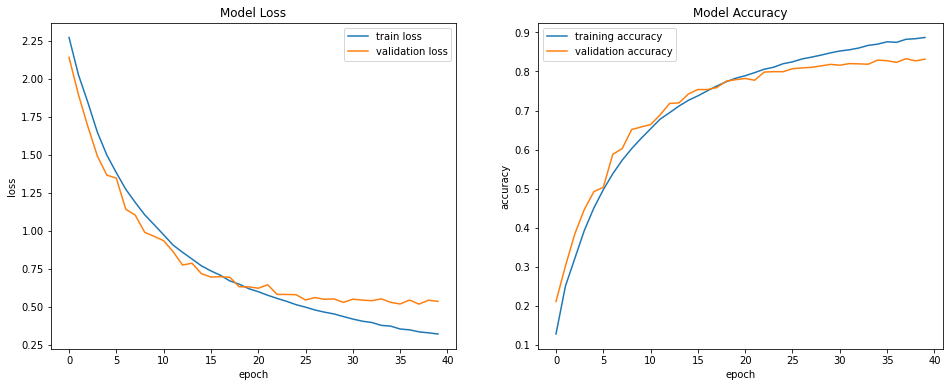

176/176 [==============================] - 27s 151ms/step - loss: 0.3214 - accuracy: 0.8872 - val_loss: 0.5357 - val_accuracy: 0.8316


In [ ]:
# Note that you can evaluate this cell repeatedly to push the training of your model further.
# You might want to reduce the value of 'num_epochs' if each evaluation starts to take too long.

num_epochs = 40

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model.fit(X_train, Y_train,
          batch_size=256, epochs=num_epochs, 
          validation_data=(X_validation, Y_validation), 
          callbacks=[pltCallBack])


In [ ]:
# write model to model.json and weights to model.h5 for submission

save_model_to_disk()

Saved model to model.json and weights to model.h5


In [ ]:
# you can now commit and push and submit lab for assessment

In [ ]:
# Question: using a combination of dense and convolutional layers, achieve 80%
#           or more accuracy on the server's test set.
#
# You may want try to:
#
#     add layers, 
#     change the number of filters per layer, 
#     use stride and various pooling layers,
#     check the effect of using valid or same padding.
#     ... and similarly to previous lab, you can always:       
#     change the optimizer
#     the learning rate,
#     add Dropout [https://keras.io/layers/core/#dropout]
#     add Regularisers (eg. L2, L1) [https://keras.io/regularizers/]
#
# Good luck!
#
# F.A.Q.
#
#   I reached 81% on my validation set, but the submission didn't pass, how come? 
#     > the test set on the server is different from your validation set
#
#   can I use convolutional layers? 
#     > yes, that's the whole point of this lab
#